<a href="https://colab.research.google.com/github/Smit250904/Player-Re-Identification/blob/main/Re_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install required packages
!pip install ultralytics opencv-python-headless deep_sort_realtime -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.7 MB/s eta 0:00:00


In [1]:
from google.colab import files

uploaded = files.upload()


Saving 15sec_input_720p.mp4 to 15sec_input_720p.mp4
Saving best.pt to best.pt


In [2]:
import os

# List files in current working directory
os.listdir()


['.config', 'best.pt', '15sec_input_720p.mp4', 'sample_data']

In [6]:
from ultralytics import YOLO

# Load the custom YOLOv11 model
model = YOLO("best.pt")

# Print the class labels
print("Classes:", model.names)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Classes: {0: 'ball', 1: 'goalkeeper', 2: 'player', 3: 'referee'}


WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.11/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.11/dist-packages/ultralytics/assets/bus.jpg: 640x480 (no detections), 3106.7ms
image 2/2 /usr/local/lib/python3.11/dist-packages/ultralytics/assets/zidane.jpg: 384x640 2 players, 2331.6ms
Speed: 7.8ms preprocess, 2719.1ms inference, 13.1ms postprocess per image at shape (1, 3, 384, 640)


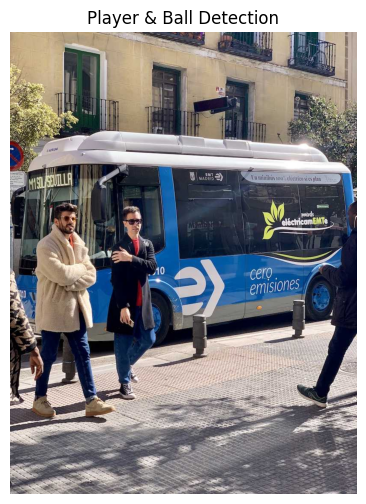

In [7]:
import cv2
import matplotlib.pyplot as plt

# Load the video
video_path = "15sec_input_720p (1).mp4"
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = cap.read()
cap.release()

# Run detection
results = model(frame)[0]

# Draw results on frame
annotated_frame = results.plot()

# Show detection
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Player & Ball Detection")
plt.show()


In [8]:
from deep_sort_realtime.deepsort_tracker import DeepSort

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=30)  # max_age controls how long to keep lost tracks


In [9]:
import cv2

# Open video
cap = cv2.VideoCapture("15sec_input_720p (1).mp4")

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
out = cv2.VideoWriter("output_tracked.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv11 detection
    results = model(frame)[0]

    # Collect detections for DeepSORT
    detections = []
    for box in results.boxes:
        cls = int(box.cls[0])
        if model.names[cls] != "player":
            continue  # Skip ball

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        detections.append(([x1, y1, x2 - x1, y2 - y1], conf, "player"))

    # Update tracker with detections
    tracks = tracker.update_tracks(detections, frame=frame)

    # Draw tracks
    for track in tracks:
        if not track.is_confirmed():
            continue
        track_id = track.track_id
        l, t, w_box, h_box = track.to_ltrb()
        cv2.rectangle(frame, (int(l), int(t)), (int(l+w_box), int(t+h_box)), (0, 255, 0), 2)
        cv2.putText(frame, f"Player {track_id}", (int(l), int(t) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Write frame
    out.write(frame)

cap.release()
out.release()
print("✅ Tracking complete. Output saved as: output_tracked.mp4")


✅ Tracking complete. Output saved as: output_tracked.mp4


In [10]:
from IPython.display import Video

# Display the output video
Video("output_tracked.mp4", embed=True)


In [11]:
import os
os.listdir()


['.config', 'best.pt', '15sec_input_720p.mp4', 'sample_data']

In [12]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Load model and video
model = YOLO("best.pt")
cap = cv2.VideoCapture("15sec_input_720p (1).mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter("output_tracked.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
tracker = DeepSort(max_age=30)

# Process video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    results = model(frame)[0]
    detections = []
    for box in results.boxes:
        cls = int(box.cls[0])
        if model.names[cls] != "player":
            continue
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        detections.append(([x1, y1, x2 - x1, y2 - y1], conf, "player"))
    tracks = tracker.update_tracks(detections, frame=frame)
    for track in tracks:
        if not track.is_confirmed():
            continue
        tid = track.track_id
        l, t, w_box, h_box = track.to_ltrb()
        cv2.rectangle(frame, (int(l), int(t)), (int(l+w_box), int(t+h_box)), (0, 255, 0), 2)
        cv2.putText(frame, f"Player {tid}", (int(l), int(t) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    out.write(frame)

cap.release()
out.release()
print("✅ output_tracked.mp4 has been saved!")


✅ output_tracked.mp4 has been saved!


In [13]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# Load model
model = YOLO("best.pt")

# Video input
cap = cv2.VideoCapture("15sec_input_720p.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output writer
out = cv2.VideoWriter("output_tracked.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

# DeepSORT tracker
tracker = DeepSort(max_age=30)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv11 detection
    results = model(frame)[0]
    detections = []

    for box in results.boxes:
        cls = int(box.cls[0])
        if model.names[cls] != "player":
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        detections.append(([x1, y1, x2 - x1, y2 - y1], conf, "player"))

    # Track players
    tracks = tracker.update_tracks(detections, frame=frame)

    # Draw tracked results
    for track in tracks:
        if not track.is_confirmed():
            continue
        tid = track.track_id
        l, t, w_box, h_box = track.to_ltrb()
        cv2.rectangle(frame, (int(l), int(t)), (int(l+w_box), int(t+h_box)), (0, 255, 0), 2)
        cv2.putText(frame, f"Player {tid}", (int(l), int(t) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    out.write(frame)

cap.release()
out.release()
print("✅ output_tracked.mp4 saved successfully!")



0: 384x640 1 ball, 16 players, 2 referees, 2340.7ms
Speed: 3.5ms preprocess, 2340.7ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 2 referees, 3190.5ms
Speed: 3.4ms preprocess, 3190.5ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 2315.2ms
Speed: 3.2ms preprocess, 2315.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 2312.4ms
Speed: 2.8ms preprocess, 2312.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 2325.3ms
Speed: 3.1ms preprocess, 2325.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 3110.0ms
Speed: 3.2ms preprocess, 3110.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 2 referees, 2305.7ms
Speed: 4.0ms preprocess, 2305.7ms inference, 1.1ms 

In [15]:
from google.colab import files
files.download("output_tracked.mp4")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
!apt-get -y install ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [17]:
!ffmpeg -i output_tracked.mp4 -vcodec libx264 -crf 30 -preset fast -vf "scale=640:-2" compressed_output.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [18]:
!du -h compressed_output.mp4


1.7M	compressed_output.mp4


In [19]:
import zipfile

with zipfile.ZipFile("compressed_best.zip", "w", compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("best.pt")

!du -h compressed_best.zip


172M	compressed_best.zip


In [20]:
with zipfile.ZipFile("submission_25mb.zip", "w") as zipf:
    zipf.write("compressed_output.mp4")
    zipf.write("compressed_best.zip")


In [21]:
from google.colab import files
files.download("submission_25mb.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
!ffmpeg -i output_tracked.mp4 -vcodec libx264 -crf 30 -preset fast -vf "scale=640:-2" compressed_output.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [23]:
!du -h compressed_output.mp4


1.7M	compressed_output.mp4


In [24]:
import zipfile

with zipfile.ZipFile("compressed_best.zip", "w", compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("best.pt")


In [25]:
!du -h compressed_best.zip
with zipfile.ZipFile("player_tracking_25mb.zip", "w") as zipf:
    zipf.write("compressed_output.mp4")
    zipf.write("compressed_best.zip")


172M	compressed_best.zip


In [26]:
from google.colab import files
files.download("player_tracking_25mb.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>